In [1]:
#imports

import pandas as pd
import seaborn as sns
import numpy as numpy
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Classifying NLP Data for the Service Industry: Comparing 2 Subreddits

## Project Contents:

This projects contains 4 notebooks:

|Name|Description|
|---|---|
|1.intro_and_webscrape|Provides an introduction to the project, including problem statement and background, and the code used for gathering the data.|
|2.eda|Displays data cleaning and exploratory data analysis.|
|3.modeling|Builds 4 classification models.|
|4.sentiment_analysis|Explores sentiment analysis of the language used in each subreddit|

You are currently in the notebook #2: EDA.


In [2]:
#reading in talesfromretail.csv

retail_df = pd.read_csv('./data/talesfromretail.csv').drop(columns='Unnamed: 0')

In [3]:
#reading in talesfromyourserver.csv

server_df = pd.read_csv('./data/talesfromyourserver.csv').drop(columns='Unnamed: 0')

In [4]:
#droppping accidental retail data points from server_df

server_df['subreddit'].value_counts()

TalesFromYourServer    186000
TalesFromRetail           100
Name: subreddit, dtype: int64

In [5]:
#deleted 'TalesFromRetail' lines from 'TalesFromYourServer' that were inadvertently added.

server_df.drop(server_df[server_df.subreddit == 'TalesFromRetail'].index, inplace=True)

In [6]:
#limiting both datasets to 40_000 data points:

server_df = server_df.sort_values(by='created_utc', ascending=False)[:40000]

In [7]:
retail_df = retail_df.sort_values(by='created_utc', ascending=False)[:40000]

In [8]:
retail_df.shape

(40000, 4)

In [9]:
server_df.shape

(40000, 4)

In [10]:
#looking at automoderator messages and determined they do not add value and should be deleted.

retail_df[retail_df['body'].str.contains('The TFR Express Lane is provided for your')][:5]

,body,subreddit,author,created_utc
2799,The TFR Express Lane is provided for your shor...,TalesFromRetail,AutoModerator,1633521622
6217,The TFR Express Lane is provided for your shor...,TalesFromRetail,AutoModerator,1630929616
7578,The TFR Express Lane is provided for your shor...,TalesFromRetail,AutoModerator,1630324829
8772,The TFR Express Lane is provided for your shor...,TalesFromRetail,AutoModerator,1629720026
10226,The TFR Express Lane is provided for your shor...,TalesFromRetail,AutoModerator,1629227343


In [11]:
# Delete AutoModerator messages

retail_df[retail_df['author'] == 'AutoModerator']['body']

2799     The TFR Express Lane is provided for your shor...
6217     The TFR Express Lane is provided for your shor...
7578     The TFR Express Lane is provided for your shor...
8772     The TFR Express Lane is provided for your shor...
10226    The TFR Express Lane is provided for your shor...
10433    The TFR Express Lane is provided for your shor...
10482    The TFR Express Lane is provided for your shor...
35630    The TFR Express Lane is provided for your shor...
36333    The TFR Express Lane is provided for your shor...
36847    The TFR Express Lane is provided for your shor...
37136    The TFR Express Lane is provided for your shor...
38471    The TFR Express Lane is provided for your shor...
39062    The TFR Express Lane is provided for your shor...
Name: body, dtype: object

In [12]:
retail_df['body'].describe()

count         40000
unique        33258
top       [removed]
freq           6117
Name: body, dtype: object

In [13]:
# Research indicates that 'Happy Cake Day' is posted on one's reddit anniversary. I will delete this entries. 

retail_df[retail_df['body'].str.contains('Happy cake day!')][:5]

,body,subreddit,author,created_utc
2270,I thought the same! Happy cake day!,TalesFromRetail,madeofmold,1633818665
2411,Happy cake day!,TalesFromRetail,meerku,1633757593
2475,Happy cake day!,TalesFromRetail,sisterwifenumber9,1633733431
8108,Happy cake day!,TalesFromRetail,Agitated-Handle-7750,1629976925
30391,Happy cake day!,TalesFromRetail,Ryger9,1619671581


In [14]:
retail_df['body'].describe()

count         40000
unique        33258
top       [removed]
freq           6117
Name: body, dtype: object

In [15]:
# A code to clean and prep my data for NLP classification modeling.  This code removes items that are not needed, tokenizes, 
# removes english stopwords, removes words of 2 letters or less, and lemmatizes the text into a new column. . 

def clean_the_data(some_reddit_df):
    #dropping 'removed' body. 
    some_reddit_df.drop(some_reddit_df[some_reddit_df.body == '[removed]'].index, inplace=True)
    #dropping 'deleted' body.
    some_reddit_df.drop(some_reddit_df[some_reddit_df.body == '[deleted]'].index, inplace=True)
    #dropping automoderator comments.
    some_reddit_df.drop(some_reddit_df[some_reddit_df.author == 'AutoModerator'].index, inplace=True)
    #dropping happy cake day comments.
    some_reddit_df.drop(some_reddit_df[some_reddit_df.body.str.contains('Happy cake day!')].index, inplace=True)
    #adding a word count column
    some_reddit_df['comment_length']=[len(comment) for comment in some_reddit_df['body']]
    #resetting the index
    some_reddit_df.reset_index(drop=True, inplace=True)
    
    
    #tokenize into a new column
    tokenizer = RegexpTokenizer(r'\w+')
    some_reddit_df['comment_tokens'] = [word_tokenize(row.lower()) for row in some_reddit_df['body']]
            
    #remove stopwords(english)
    for line in some_reddit_df['comment_tokens']:
        for idx, token in enumerate(line):
            if token in stopwords.words('english'):
                line.pop(idx)
            
    #lemmatize
    lemmatizer = WordNetLemmatizer()
    for row  in some_reddit_df['comment_tokens']:
        for item in row:
            lemmatizer.lemmatize(item)
            
    #remove words with 2 letters or less. 
    for line in some_reddit_df['comment_tokens']:
        for idx, word in enumerate(line):
            if len(word) <= 2:
                line.pop(idx)
       
    #joined tokens
    some_reddit_df['comment_tokens'] = [' '.join(word) for word in some_reddit_df['comment_tokens']]
    


    


In [16]:
#Cleaning the talesfromyourserver data

clean_the_data(server_df)

In [17]:
server_df.head()

,body,subreddit,author,created_utc,comment_length,comment_tokens
0,"Yes, your local health department will have a ...",TalesFromYourServer,MistressMaiden,1635308008,63,yes local health department have hay day this
1,Call the local health department and local new...,TalesFromYourServer,Hum_cat_7711,1635307985,50,call local health department local news
2,Normal day when serving,TalesFromYourServer,jenatalias,1635307799,23,normal day serving
3,It really sucks when bad things happen to go...,TalesFromYourServer,ZebonskiSam,1635307756,512,really sucks bad things happen good people lot...
4,Lawyer wanting people to go to lawyers? Surprise?,TalesFromYourServer,Justgetmeabeer,1635307726,49,lawyer wanting people lawyers surprise


In [18]:
#cleaning the talesfromretail data. 

clean_the_data(retail_df)

In [19]:
server_df.head()

,body,subreddit,author,created_utc,comment_length,comment_tokens
0,"Yes, your local health department will have a ...",TalesFromYourServer,MistressMaiden,1635308008,63,yes local health department have hay day this
1,Call the local health department and local new...,TalesFromYourServer,Hum_cat_7711,1635307985,50,call local health department local news
2,Normal day when serving,TalesFromYourServer,jenatalias,1635307799,23,normal day serving
3,It really sucks when bad things happen to go...,TalesFromYourServer,ZebonskiSam,1635307756,512,really sucks bad things happen good people lot...
4,Lawyer wanting people to go to lawyers? Surprise?,TalesFromYourServer,Justgetmeabeer,1635307726,49,lawyer wanting people lawyers surprise


In [20]:
# concatenating retail_df and server_df into one dataframe for modeling. 

full_df = pd.concat([retail_df, server_df], ignore_index=True)

In [21]:
#double checking to drop duplicates

full_df.drop_duplicates(ignore_index=True, inplace=True)

In [22]:
full_df.shape

(71905, 6)

In [23]:
#saving the full dataframe as a csv. 

full_df.to_csv('./data/server_retail.csv',index=False)

### A Comparison of Comment Length

Looking at the histograms below, we can see that comment lengths of both subreddits follow the same pattern, with most comments falling between 1 and 200 words. 

In [24]:
full_df['comment_length'].groupby(full_df['subreddit']).describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
TalesFromRetail,33459.0,210.393706,234.140322,1.0,67.0,136.0,268.0,5319.0
TalesFromYourServer,38446.0,230.120065,283.154328,1.0,66.0,144.0,287.0,5793.0


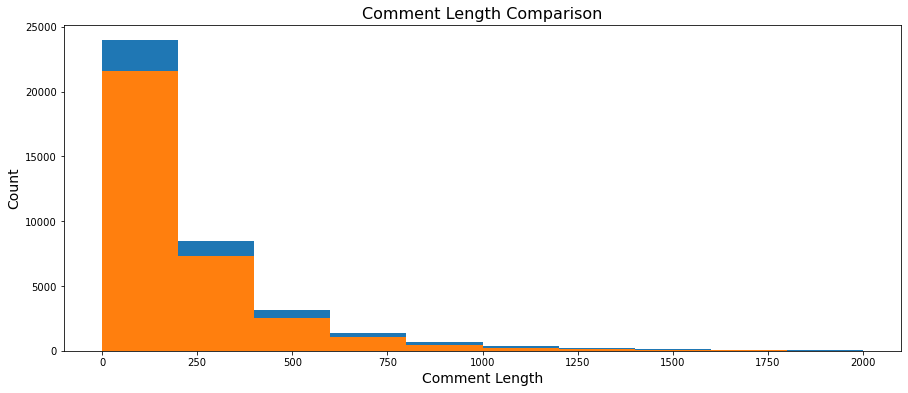

In [25]:
plt.figure(figsize=(15,6))
ax1 = plt.subplot(1, 1, 1)
ax1.hist(server_df['comment_length'], bins=10, range=(0,2000))
plt.title('Comment Length Comparison', fontsize=16)
plt.xlabel('Comment Length', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax1.hist(retail_df['comment_length'], bins=10, range=(0,2000));


### Visualizing the Top Words for each Subreddit

In [26]:
# Instanting tfidfvectorizer transformer to begin analyzing words that are strong features of each subreddit. 

tvec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=2000)

In [27]:
#Creating a dataframe of the top words from Retail. 

retail_transform_df = pd.DataFrame(tvec.fit_transform(retail_df['comment_tokens']).todense(), 
                          columns=tvec.get_feature_names())


retail_top = pd.DataFrame(retail_transform_df.sum().sort_values(ascending=False).head(16), columns= ['Retail'] )


In [28]:
#Creating a dataframe of the top words from Server. 

server_transform_df = pd.DataFrame(tvec.fit_transform(server_df['comment_tokens']).todense(), 
                          columns=tvec.get_feature_names())

server_top = pd.DataFrame(server_transform_df.sum().sort_values(ascending=False).head(15), columns=['Server'])


In [29]:
# Retail has a lingering 've' that I am dropping for purposes of seeing the top 15 words. 

retail_top.drop(labels='ve', inplace=True)


In [30]:
# Combinging top words dataframes for retail and server. 

top_words = pd.concat([retail_top, server_top], axis=1, join='outer').sort_values(by='Retail')



While both subreddits have several top words in common, a few differences include:
 
Server: 
* tip
* restaurant
* server
* food

Retail:
* store
* customer

''

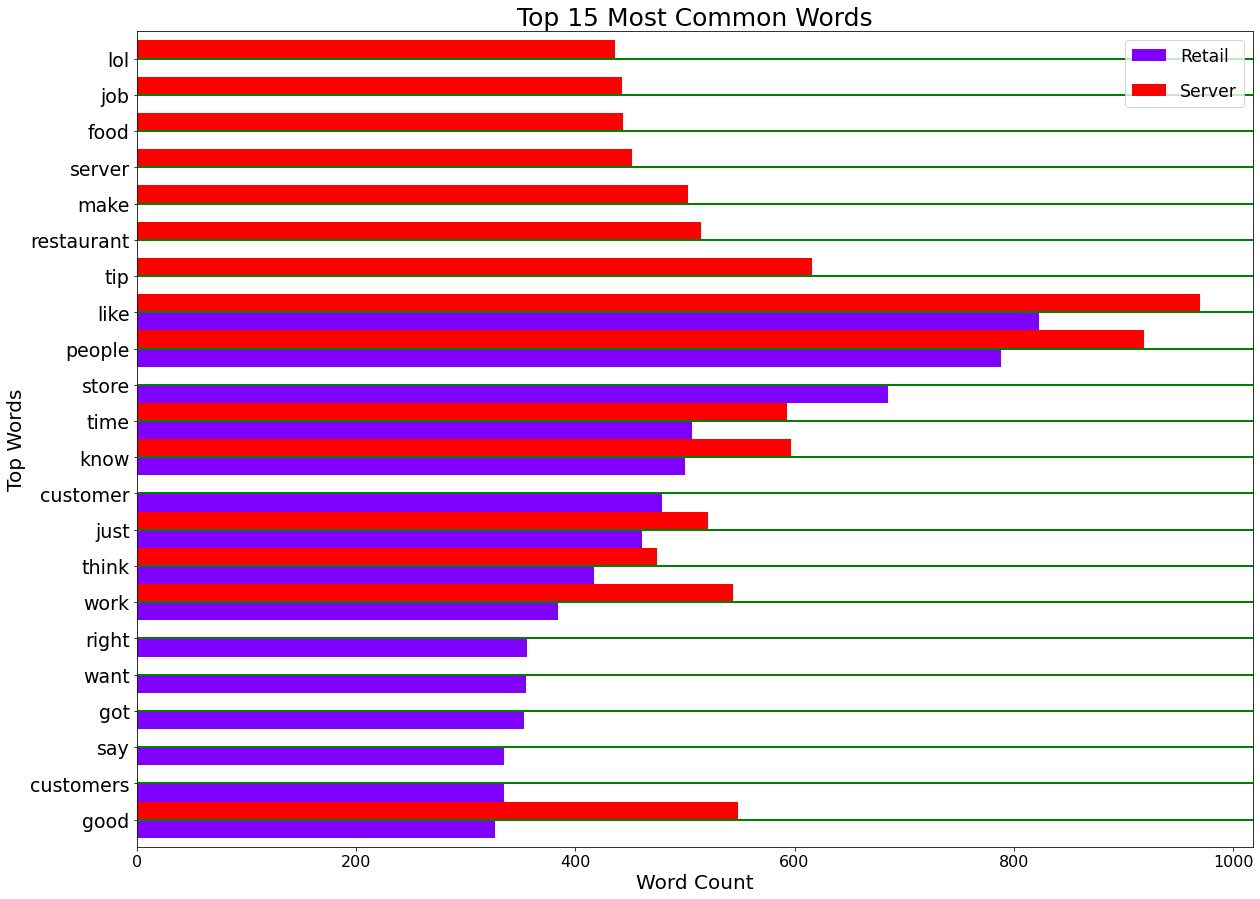

In [31]:
# Plotting the top 15 words
top_words.plot(colormap='rainbow', use_index=True, y=["Retail", "Server"], kind="barh", figsize=(20,15), width=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=19)
plt.legend(fontsize='xx-large', labelspacing=1)
plt.title('Top 15 Most Common Words', fontsize=25)
plt.xlabel('Word Count', fontsize=20)
plt.ylabel('Top Words', fontsize=20)
plt.grid(b=True, color='g', linestyle='-', linewidth=2, dash_capstyle='butt', axis='y' )
;
